In [1]:
%load_ext autoreload
%autoreload 2

import importlib
import cv2
import yaml

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

In [2]:
def convert_y_label_to_string(y, dataset):
    return ''.join([dataset.mapper(int(i)) for i in y])

In [3]:
from text_recognizer.models import TransformerModel
from text_recognizer.datasets import IamLinesDataset

In [4]:
dataset = IamLinesDataset(train=False,
        init_token="<sos>",
        pad_token="_",
        eos_token="<eos>",
        transform=[{"type": "ToTensor", "args": {}}],
        target_transform=[
            {
                "type": "AddTokens",
                "args": {"init_token": "<sos>", "pad_token": "_", "eos_token": "<eos>"},
            }
        ],
    )
dataset.load_or_generate_data()

In [6]:
config_path = "../training/experiments/TransformerModel_IamLinesDataset_CNNTransformer/1116_082932/config.yml"
with open(config_path, "r") as f:
    experiment_config = yaml.safe_load(f)

In [8]:
experiment_config["network"]["type"]

'CNNTransformer'

In [13]:
model = TransformerModel(network_fn=experiment_config["network"]["type"], dataset=experiment_config["dataset"]["type"], dataset_args=experiment_config["dataset"])

2020-11-16 20:07:51.973 | DEBUG    | text_recognizer.models.base:load_weights:432 - Loading network with pretrained weights.


In [ ]:
checkpoint_path = "../training/experiments/VisionTransformerModel_IamLinesDataset_CNNTransformer/1102_221553/model/last.pt"
model.load_from_checkpoint(checkpoint_path)

In [14]:
model.eval()

In [95]:
data, target = dataset[1006]
sentence = convert_y_label_to_string(target, dataset) 

In [102]:
data1 = (data - data.mean()) / data.std()

In [103]:
target.shape

torch.Size([98])

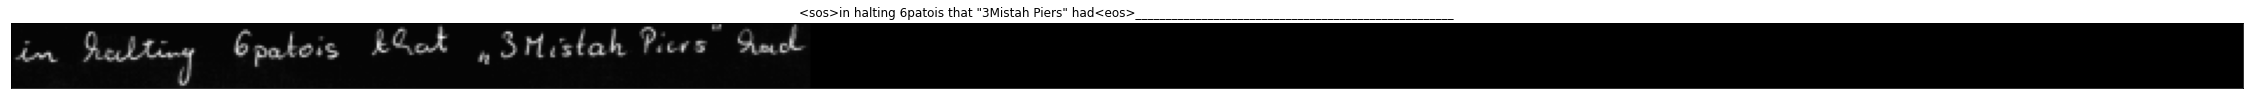

In [110]:
plt.figure(figsize=(40, 20))
plt.title(sentence)
plt.imshow(data1.squeeze(0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [111]:
model.predict_on_image(data1)

('Horbwargethers sis tHater alate Bate Bath Con Hats the Bateries.<eos>',
 0.2612667977809906)

In [110]:
data, target = dataset[110]
sentence = convert_y_label_to_string(target, dataset) 

([], [])

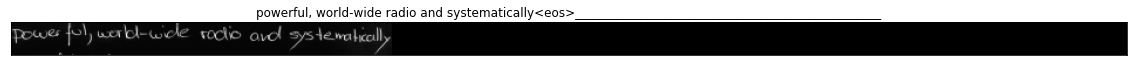

In [111]:
plt.figure(figsize=(20, 20))
plt.title(sentence)
plt.imshow(data.squeeze(0).numpy(), cmap='gray')
plt.xticks([])
plt.yticks([])

In [112]:
model.predict_on_image(data)

('Boyis cheed iitrincy- tarisaing one', 0.3990435302257538)

In [95]:
experiment_config["train_args"]["input_shape"]

[[1, 28, 952], [92]]

In [99]:
model.summary(experiment_config["train_args"]["input_shape"], 4)

Layer (type:depth-idx)                                  Output Shape              Param #
├─Sequential: 1-1                                       [-1, 158, 1, 28, 6]       --
|    └─Unfold: 2-1                                      [-1, 168, 158]            --
|    └─Rearrange: 2-2                                   [-1, 158, 1, 28, 6]       --
├─Linear: 1-2                                           [-1, 158, 512]            86,528
├─PositionalEncoding: 1-3                               [-1, 158, 512]            --
|    └─Dropout: 2-3                                     [-1, 158, 512]            --
├─Embedding: 1-4                                        [-1, 92, 512]             41,984
├─PositionalEncoding: 1-5                               [-1, 92, 512]             --
|    └─Dropout: 2-4                                     [-1, 92, 512]             --
├─Transformer: 1-6                                      [-1, 92, 512]             --
|    └─Encoder: 2-5                                 

In [61]:
t=[12,1,1,1,1,1,4,4,4,4,4]

In [62]:
t[t!=79]

1

In [63]:
x = torch.arange(10)
value = 5
x = x[x!=value]

In [64]:
x

tensor([0, 1, 2, 3, 4, 6, 7, 8, 9])

In [7]:
t = torch.rand(98)

In [8]:
t.cumprod(dim=0)[-1]

tensor(1.7656e-43)

In [24]:
pred_tokens = torch.Tensor([1,2,21,31, 89, 89])

In [25]:
pred_tokens = torch.stack([pred_tokens, pred_tokens])

In [26]:
pred_tokens

tensor([[ 1.,  2., 21., 31., 89., 89.],
        [ 1.,  2., 21., 31., 89., 89.]])

In [27]:
eos_token_index = torch.nonzero(
            pred_tokens == 89, as_tuple=False,
        )

In [31]:
if eos_token_index.nelement():
    print(eos_token_index[0][0].item())

0


In [32]:
eos_token_index

tensor([[0, 4],
        [0, 5],
        [1, 4],
        [1, 5]])

In [29]:
eos_token_index.nelement()

8

In [38]:
from text_recognizer.models import accuracy

In [44]:
pred = torch.Tensor([1,2,21,31, 80, 80]).unsqueeze(0)
target = torch.Tensor([1,2,1,31, 80, 80]).unsqueeze(0)

In [57]:
pred = torch.stack([pred, pred])
target = torch.stack([target, target])

In [115]:
target = torch.tensor([0, 1, 2, 3])
pred = torch.tensor([0, 2, 1, 3])

In [116]:
accuracy(pred, target)

0.5

In [53]:
acc = (target.argmax(-1) == pred.argmax(-1)).float()

# return float(100 * acc.sum() / len(acc))

In [54]:
acc

tensor([[1.],
        [1.]])

In [58]:
train_acc = (pred == target).sum().item()/target.shape[-1]

In [59]:
train_acc

3.3333333333333335